# Описание проекта

Допустим, вы работаете в добывающей компании. Нужно решить, где бурить новую скважину. 

Шаги для выбора локации обычно такие:

- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.

Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap*.

In [1]:
unit_price = 450000  #Цена за единицу сырья в Рублях
budget = 10000000000  #Бюджет на разработку скважин в регионе в Рублях
num_wells = 200  #Количество скважин
n_samples = 1000 #объем выборки для bootstrap
sample_size = 500 #отбираемые скважины

## Загрузка и подготовка данных

In [2]:
!pip install scikit-learn==1.1.3 -q
!pip install missingno -q
!pip install phik -q

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import (StandardScaler, 
                                   PolynomialFeatures)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error
import phik
from sklearn.ensemble import GradientBoostingRegressor

In [4]:
df_geo_1 = pd.read_csv('/datasets/geo_data_0.csv', decimal='.')
df_geo_2 = pd.read_csv('/datasets/geo_data_1.csv', decimal='.')
df_geo_3 = pd.read_csv('/datasets/geo_data_2.csv', decimal='.')
df_geo_1.name = 'df_geo_1'
df_geo_2.name = 'df_geo_2'
df_geo_3.name = 'df_geo_3'

data_list = [df_geo_1, df_geo_2, df_geo_3]

for i in data_list:
    print('\n', i.name)
    display(i.sample(10))


 df_geo_1


,id,f0,f1,f2,product
5547,VVsLI,1.786495,-0.228565,1.712276,84.011794
94410,G0wlU,0.112128,1.009766,0.953190,106.056336
78189,Fs21s,0.556858,1.057639,6.299658,110.115824
9170,gymnk,1.990265,0.157985,3.859099,54.184612
34542,GTWdQ,0.868078,0.162144,4.807513,49.897721
94099,wnUNB,-0.735434,0.469205,9.993311,124.299868
15306,fm2cM,0.658052,0.673041,1.651441,52.661148
34324,2Q2ex,-0.920650,0.222868,-3.289268,35.885129
86950,l5H0X,0.792428,0.224859,-0.927728,23.877776
57814,mSPm1,0.291692,-0.240606,-2.881633,135.396592



 df_geo_2


,id,f0,f1,f2,product
45709,S13Tj,13.455188,-5.048262,5.003601,134.766305
65910,kVCWx,7.671110,-6.760952,1.003040,26.953261
1177,tefBo,-2.348758,-6.286693,2.001515,57.085625
41929,EWhSX,9.071212,-7.455971,2.999152,80.859783
87270,IWjO9,-9.186996,-12.028194,0.001280,3.179103
99686,7ejcO,-4.892025,-3.685988,5.005641,137.945408
97135,FlaEq,12.350867,0.123099,1.000043,26.953261
2351,P9jlg,-5.073177,-0.628438,4.000039,110.992147
98763,aUACx,-7.196571,-15.425771,2.001518,57.085625
50797,i90HO,7.114415,1.489571,2.993045,80.859783



 df_geo_3


,id,f0,f1,f2,product
42764,9AbU4,-0.945286,1.253016,5.793113,132.388137
52,IMTor,-3.661778,-0.842655,-3.511258,128.999242
81788,ycC86,-1.122001,0.014561,-2.917712,47.073294
94958,kOYZW,1.653711,-1.943780,8.003265,114.178657
4311,JmGIq,-1.998013,-1.714118,3.417312,126.396580
54578,GnV1l,-2.167506,0.941668,3.712964,140.393617
23287,aemzv,-3.848750,0.691758,1.459650,172.569209
15462,w4Od2,0.283924,1.289962,-0.161725,37.644169
67304,OlXnl,0.783311,-0.055874,-1.642049,84.946108
13032,0UaoA,-1.367143,-1.234352,8.185228,97.407049


In [5]:
for i in data_list:
    print('\n', i.name)
    display(i.info())


 df_geo_1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


 df_geo_2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


 df_geo_3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [6]:
for i in data_list:
    print('\n', i.name)
    display(i.describe())


 df_geo_1


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



 df_geo_2


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



 df_geo_3


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


**Наблюдения**
- Пропуски не обнаружены;
- Возможно, есть небольшие выбросы в таблице 2 и 3 по признакам f1 и f2, это определим в анализе распределения данных;
- Выполню проверку на явные дубликаты без столбца id, чтобы исключить сильную переобучаемость модели.

### Предподготовка

In [7]:
for i in data_list:
    print('\n', i.name)
    display(i.duplicated(subset=i.columns[1:]).sum())


 df_geo_1


0


 df_geo_2


0


 df_geo_3


0

In [8]:
for i in data_list:
    print('\n', i.name)
    display(i.duplicated().sum())


 df_geo_1


0


 df_geo_2


0


 df_geo_3


0

In [9]:
for i in data_list:
    print('\n', i.name)
    print(i['id'].value_counts())


 df_geo_1
bsk9y    2
bxg6G    2
74z30    2
AGS9W    2
TtcGQ    2
        ..
yWB3V    1
nVt9x    1
zK8w0    1
30saK    1
d1cNB    1
Name: id, Length: 99990, dtype: int64

 df_geo_2
wt4Uk    2
bfPNe    2
5ltQ6    2
LHZR0    2
YSyM4    1
        ..
iLKBf    1
wa9Ec    1
MDbMY    1
fALjQ    1
EyyAs    1
Name: id, Length: 99996, dtype: int64

 df_geo_3
xCHr8    2
VF7Jo    2
Vcm5J    2
KUPhW    2
VQjtR    1
        ..
cKCN5    1
wGgfS    1
lwrNO    1
Mt1yV    1
X0Jy6    1
Name: id, Length: 99996, dtype: int64


In [10]:
for i in data_list:
    print('\n', i.name)
    i = i.drop_duplicates(subset=i.columns[0], keep='first')
    print (i['id'].value_counts())


 df_geo_1
snCVp    1
QZ9LM    1
18kt9    1
tuz5p    1
Ue1K8    1
        ..
nVt9x    1
zK8w0    1
30saK    1
nP2U0    1
d1cNB    1
Name: id, Length: 99990, dtype: int64

 df_geo_2
YSyM4    1
BbxDy    1
JJiau    1
gfHZf    1
7C2Fl    1
        ..
MDbMY    1
fALjQ    1
Y7IUQ    1
Jn5hU    1
EyyAs    1
Name: id, Length: 99996, dtype: int64

 df_geo_3
VQjtR    1
8hjKc    1
xCHr8    1
MaiLq    1
HFsG7    1
        ..
cKCN5    1
wGgfS    1
lwrNO    1
Mt1yV    1
X0Jy6    1
Name: id, Length: 99996, dtype: int64


**Наблюдения**
- Явных и неявных дубликатов не обнаружено;
- В стобце ID встречаются повторы по скважинам, но характеристики признаков у них разные. Так или иначе, принял подобное явление за ошибку выгрузки данных, ошибочные данные занимают менее 1% и были исключены.

### Исследовательский анализ

In [11]:
#функции для построения графиков

def hist(df,target,bins,title,x_name):
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df[target], bins=bins, alpha=0.5, color='blue', ec='green')
    plt.title(f'График распределения {title}', fontsize=14)
    plt.xlabel(f'{x_name}', fontsize=14)
    plt.ylabel('Частота наблюдений', fontsize=14)
    plt.grid(True)
    plt.show()
    
def box(df,target,title,x_name): 
    plt.figure(figsize=(12,6))
    sns.boxplot(data=df, x=target, palette='pastel')
    plt.title(f'Анализ показателей {title}', fontsize=14)
    plt.xlabel(f'{x_name}', fontsize=14)
    plt.xticks(fontsize=10)
    plt.grid(True)
    plt.show()

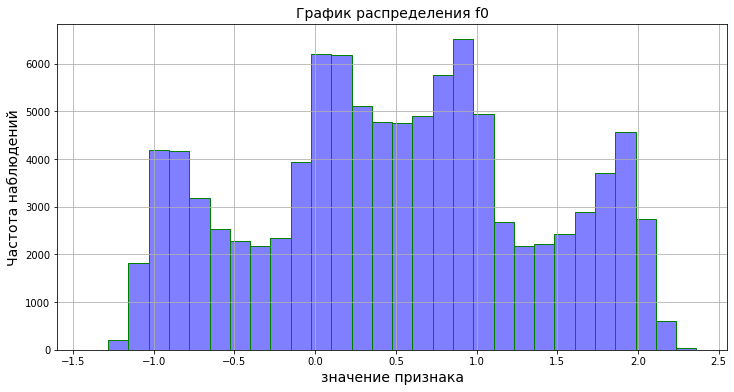

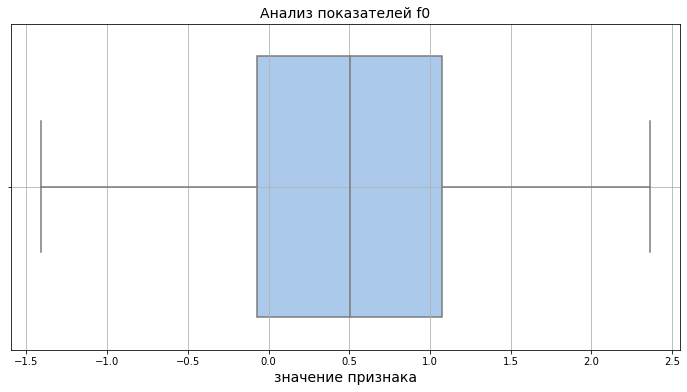

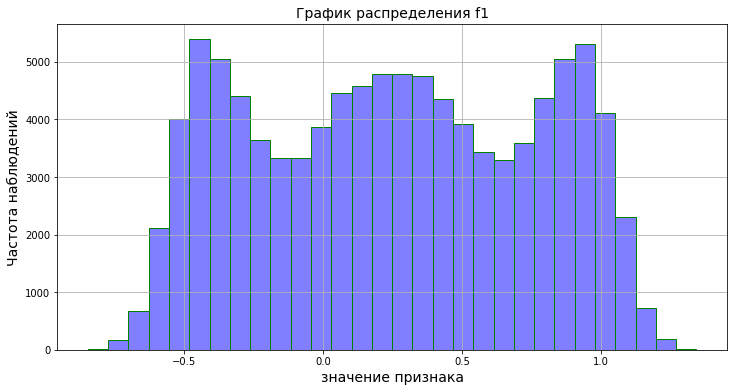

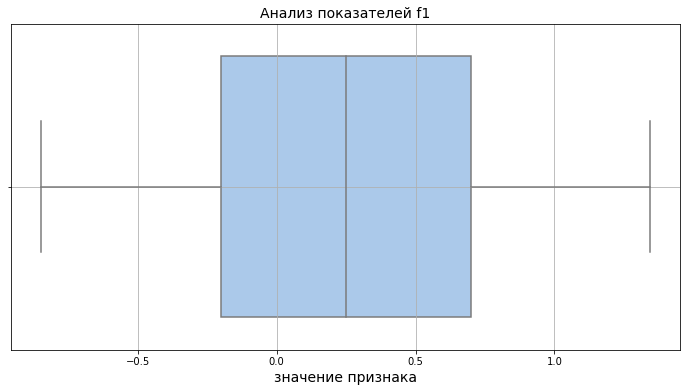

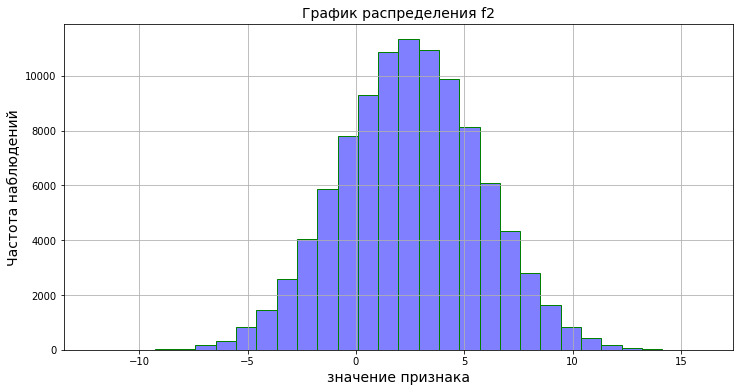

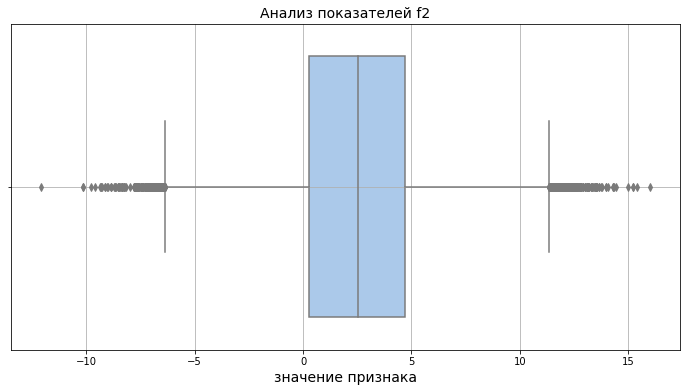

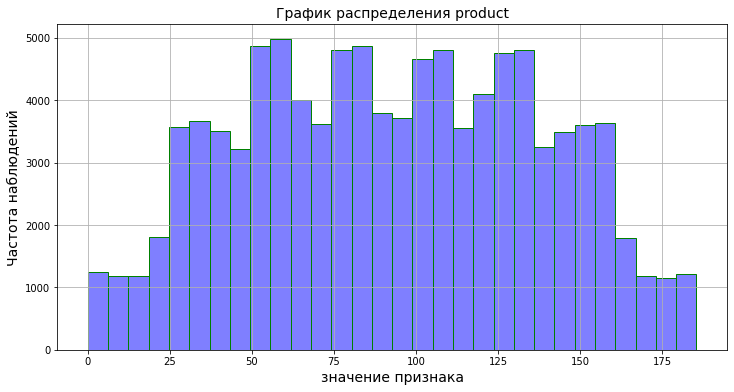

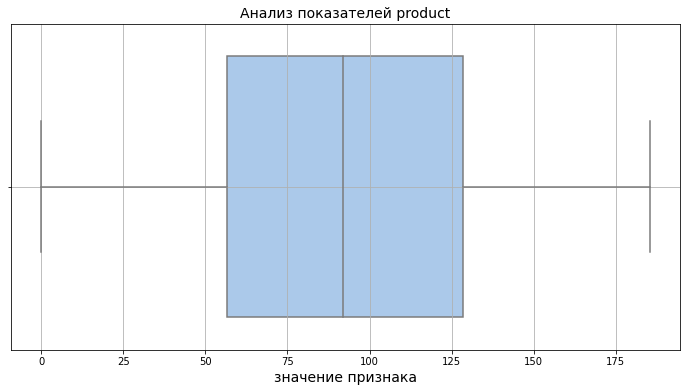

In [12]:
for i in df_geo_1.columns[1:]:
    hist(df_geo_1,i,30,i,'значение признака')
    box(df_geo_1,i,i,'значение признака')

In [13]:
display(df_geo_1.loc[df_geo_1['f2'] < -6, ['f2']].count())
display(df_geo_1.loc[df_geo_1['f2'] > 11, ['f2']].count())
x=781/10000*100
print(f'Доля выбросов f0 от общего количества наблюдений:{x:.2f}%')

f2    370
dtype: int64

f2    381
dtype: int64

Доля выбросов f0 от общего количества наблюдений:7.81%


*Наблюдаем явное **мультимодальное** распределение признаков f0 и f1. Отчетливо видны несколько пиков. Можно сделать вывод о кластеризации признаков.* 

*Распределение показателя **f2** абсолютно нормальное, но наблюдаем выбросы от -13 до -6 и от 11 до 16, общее число которых составляет 8% от общего количества наблюдений. Поскольку не известно, может ли такое встречаться в реальной жизни, ввиду неопределенности в понимании признака f2 - принимаю решение оставить данные, как есть.*


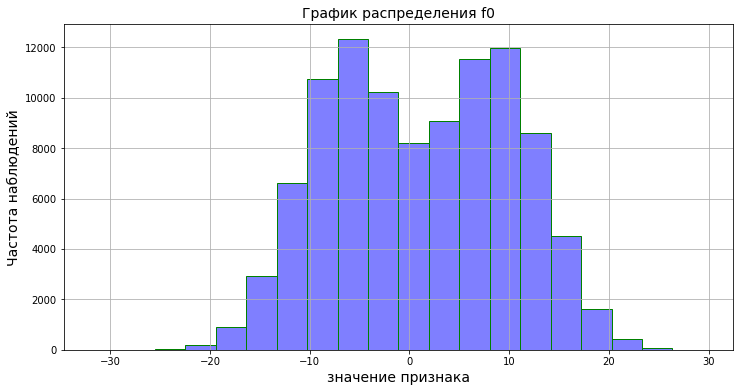

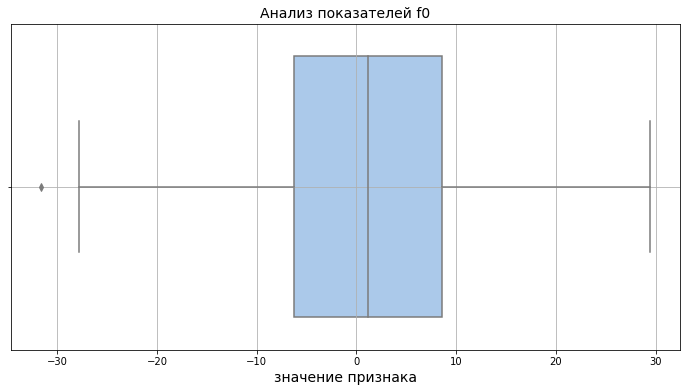

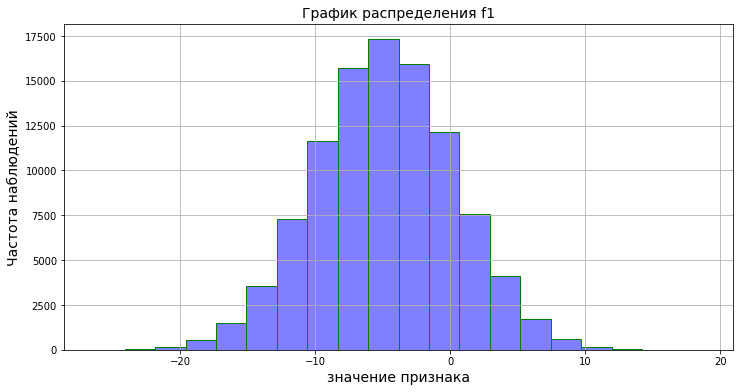

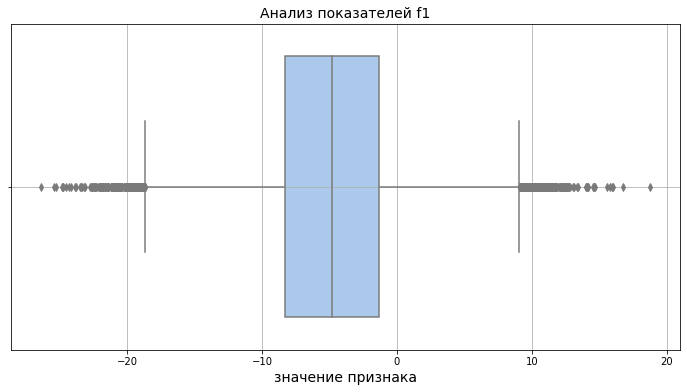

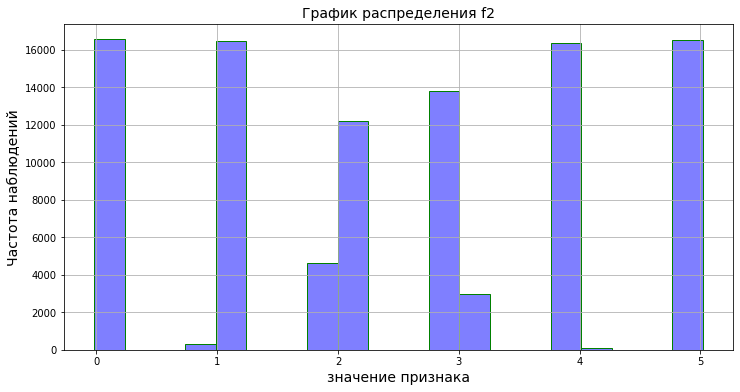

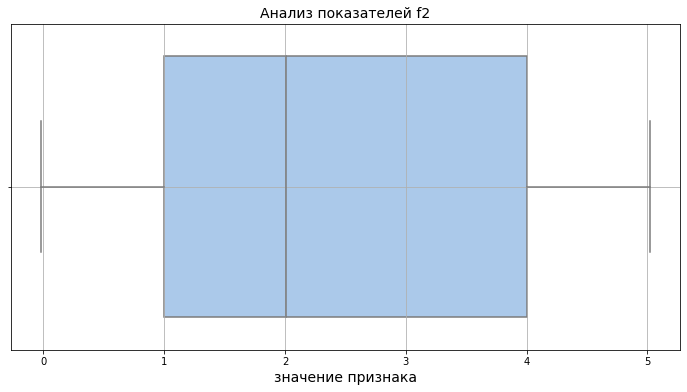

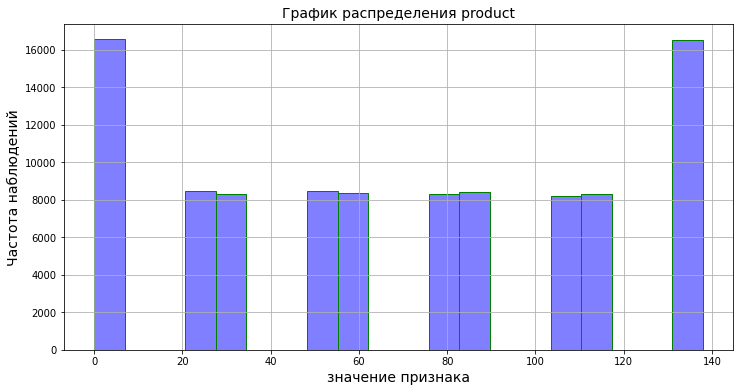

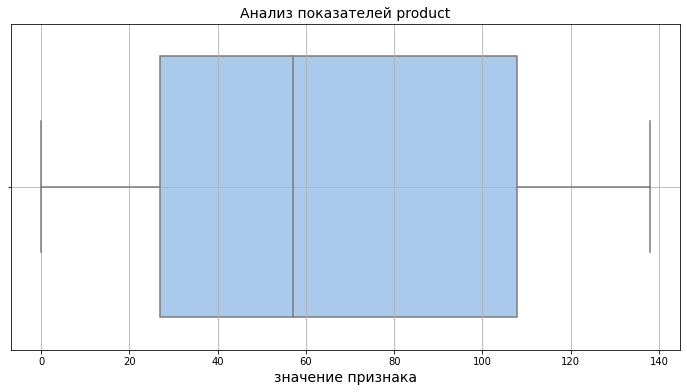

In [14]:
for i in df_geo_2.columns[1:]:
    hist(df_geo_2,i,20,i,'значение признака')
    box(df_geo_2,i,i,'значение признака')

In [15]:
display(df_geo_2.loc[df_geo_1['f2'] < -6, ['f2']].count())
display(df_geo_2.loc[df_geo_1['f2'] > 11, ['f2']].count())
x2=781/10000*100
print(f'Доля выбросов от общего количества наблюдений:{x2:.2f}%')

f2    370
dtype: int64

f2    381
dtype: int64

Доля выбросов от общего количества наблюдений:7.81%


*В таблице 2 также видим **мультимодальное** распределение признаков, но на этот раз f0 и f2. Отчетливо видны несколько пиков. Можно сделать вывод о кластеризации признаков.*

*Теперь распределение показателя **f1** нормальное, но наблюдаем выбросы от -28 до -18 и от 9 до 18, общее число которых также составляет 8%. Пока что оставляем данные, как есть.*

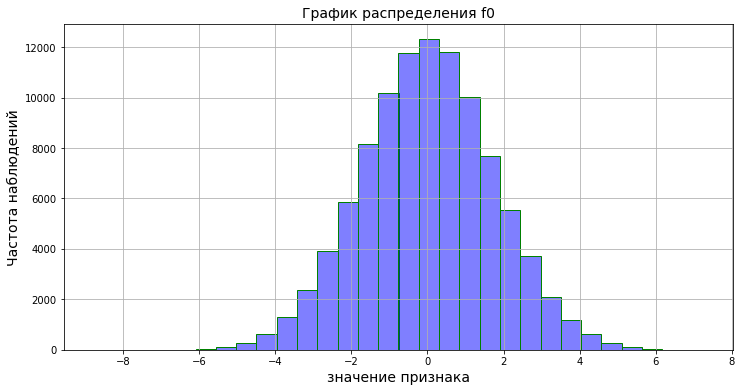

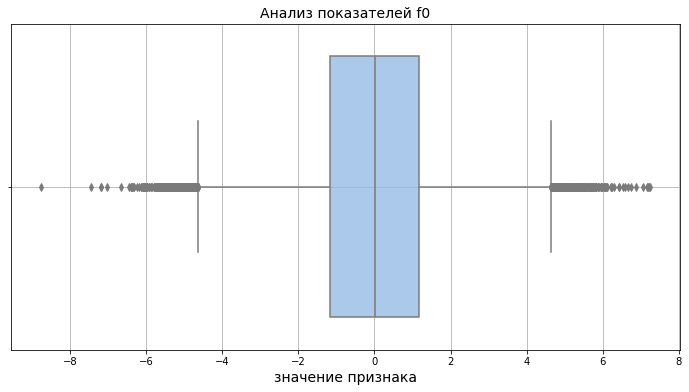

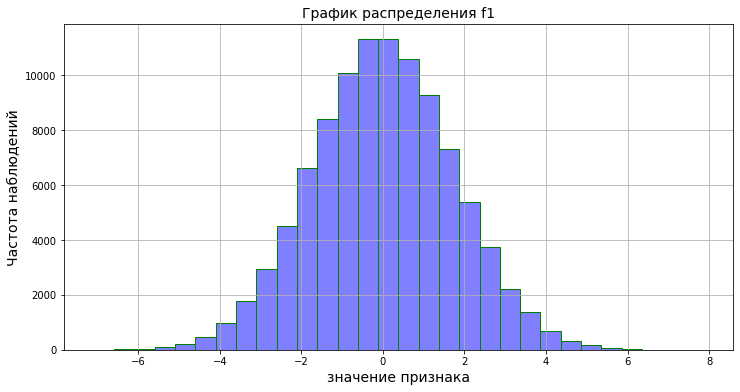

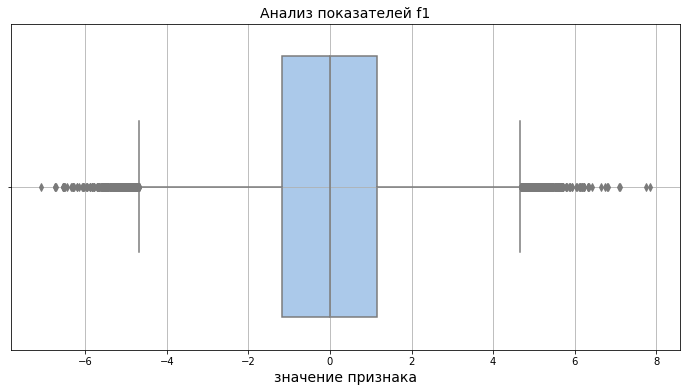

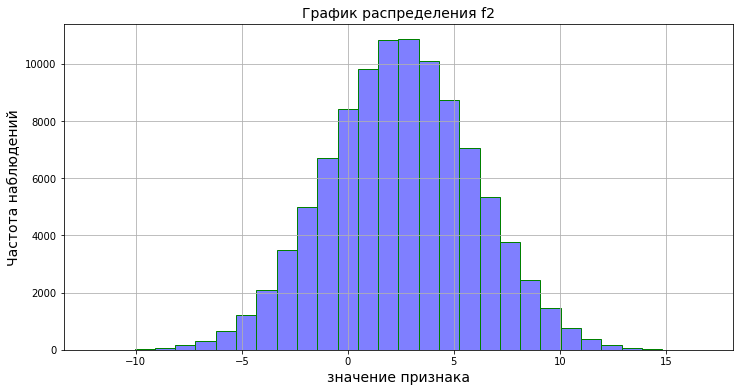

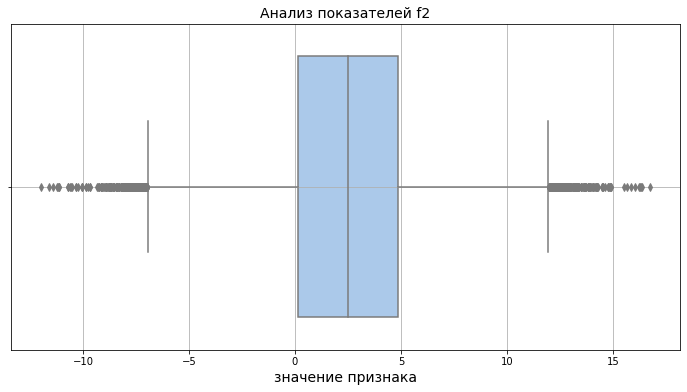

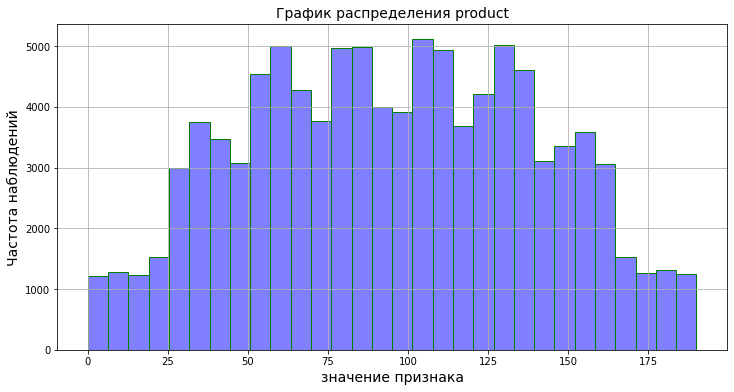

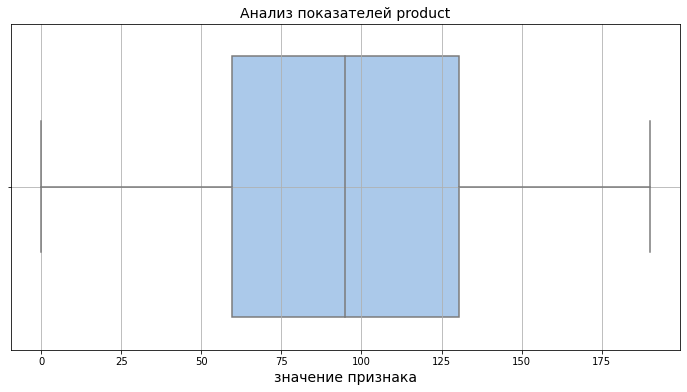

In [16]:
for i in df_geo_3.columns[1:]:
    hist(df_geo_3,i,30,i,'значение признака')
    box(df_geo_3,i,i,'значение признака')

In [17]:
display(df_geo_3.loc[df_geo_3['f0'] < -5, ['f0']].count())
display(df_geo_3.loc[df_geo_3['f0'] > 5, ['f0']].count())

display(df_geo_3.loc[df_geo_3['f1'] < -5, ['f1']].count())
display(df_geo_3.loc[df_geo_3['f1'] > 5, ['f1']].count())

display(df_geo_3.loc[df_geo_3['f2'] < -6, ['f2']].count())
display(df_geo_3.loc[df_geo_3['f2'] > 12, ['f2']].count())

x3=(185+197)/10000*100
x4=(182+206)/10000*100
x5=(689+277)/10000*100

print(f'Доля выбросов f0 от общего количества наблюдений:{x3:.2f}%')
print(f'Доля выбросов f1 от общего количества наблюдений:{x4:.2f}%')
print(f'Доля выбросов f2 от общего количества наблюдений:{x5:.2f}%')

f0    185
dtype: int64

f0    197
dtype: int64

f1    182
dtype: int64

f1    206
dtype: int64

f2    689
dtype: int64

f2    277
dtype: int64

Доля выбросов f0 от общего количества наблюдений:3.82%
Доля выбросов f1 от общего количества наблюдений:3.88%
Доля выбросов f2 от общего количества наблюдений:9.66%


*В 3 таблице распределение **нормальное** у всех признаков, кроме product (тут все еще мультимодальность), зато вот выбросы также теперь также есть в каждом признаке.* 

*Доля выбросов f0 и f1 4%, а у f2 10% от общего числа наблюдений в таблице*

### Корреляционный анализ

In [18]:
# функция шрафика scatter
def scatter(df, feature_first,feature_second):
    plt.figure(figsize=(12,8))
    sns.scatterplot(data=df, x=feature_first, y=feature_second, 
                    alpha=0.3, color='green', hue='product')
    plt.title(f'График распределения признаков {feature_first,feature_second} относительно целевого product', fontsize=14)
    plt.xlabel(f'{feature_first}', fontsize=14)
    plt.ylabel(f'{feature_second}', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

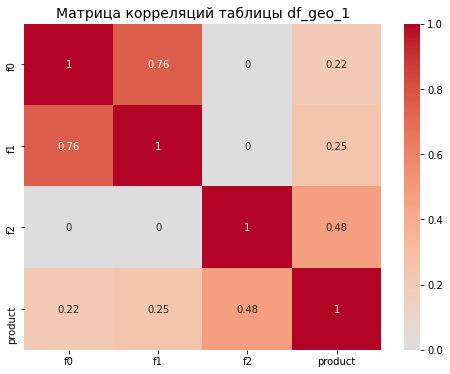

In [19]:
corr_data_1 = df_geo_1.drop('id', axis=1).copy()
col_int_1 = corr_data_1.select_dtypes(include='number').columns.to_list()
corr_1 = corr_data_1.phik_matrix(interval_cols=col_int_1)

plt.figure(figsize=(8,6))
sns.heatmap(data=corr_1, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций таблицы df_geo_1', fontsize=14)
plt.show()

*Целевой признак Product связан с каждым из признаков, но сильной зависимости не прослеживается*

*f1 и f0 имеют сильную сонаправленную зависимость = 0.76. Думаю, что для улучшения качества модели стоит добавить новый признак, равный произведению f0 и f1, либо закодировать/масштабировать данные*

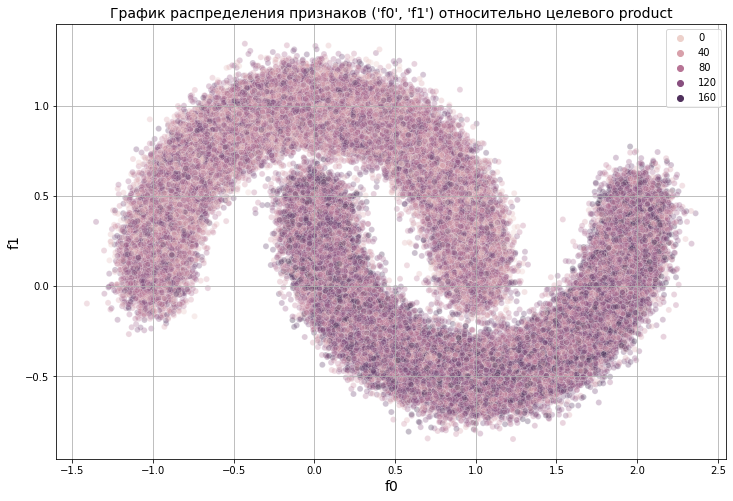

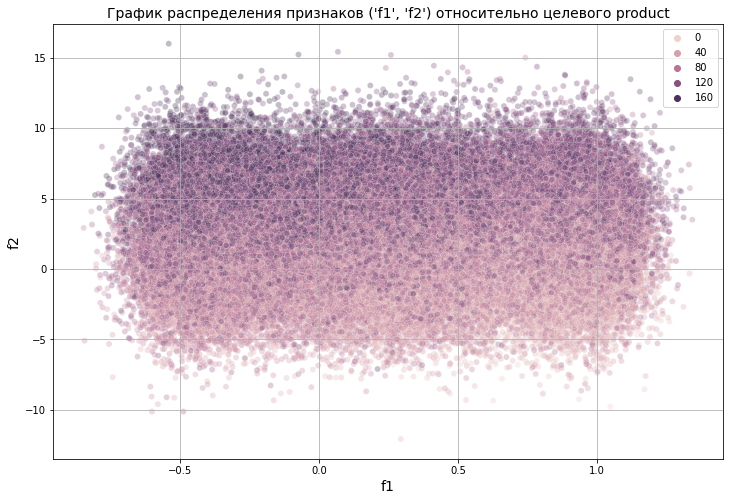

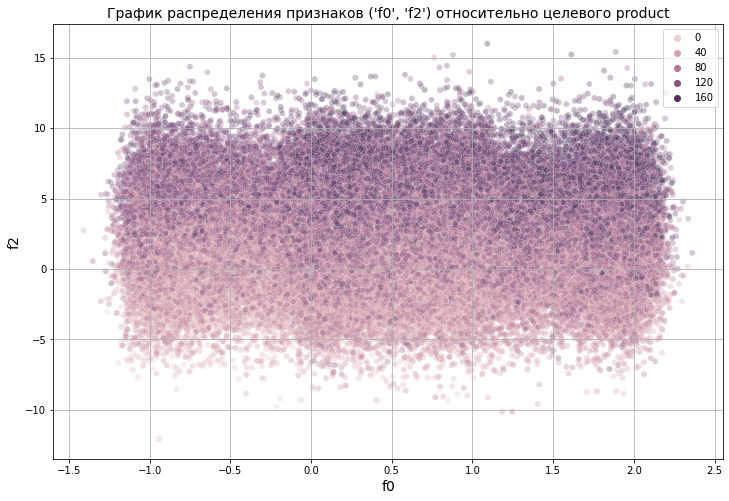

In [20]:
scatter(df_geo_1, 'f0', 'f1')
scatter(df_geo_1, 'f1', 'f2')
scatter(df_geo_1, 'f0', 'f2')

*Крайне интересно распределяется основной признак относительно f0 и f1 в первой таблице. Выборка у нас полностью синтетическая. Получается ситуация, что между признаками сложная нелинейная зависимость. Линейная регрессия плохо подходит для данных с таким распределением, так как она предполагает линейные зависимости между признаками и целевым значением. Попробую создать новые признаки, перемножив уже имеющиеся между собой, а также проверить варианты с полиномами.*

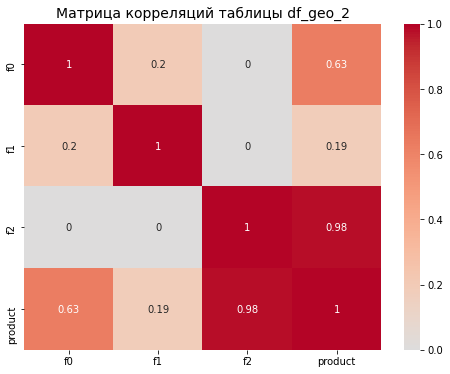

In [21]:
corr_data_2 = df_geo_2.drop('id', axis=1).copy()
col_int_2 = corr_data_2.select_dtypes(include='number').columns.to_list()
corr_2 = corr_data_2.phik_matrix(interval_cols=col_int_2)

plt.figure(figsize=(8,6))
sns.heatmap(data=corr_2, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций таблицы df_geo_2', fontsize=14)
plt.show()

*В таблице 2 признак f2 фактически объясняет Product, связь между ними 0.98. На мой взгляд, f2 также стоит закодировать/масштабировать для улучшения качества модели.*

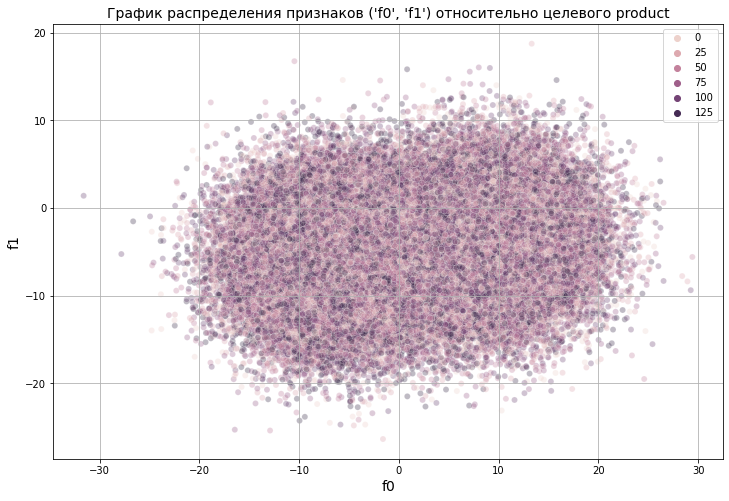

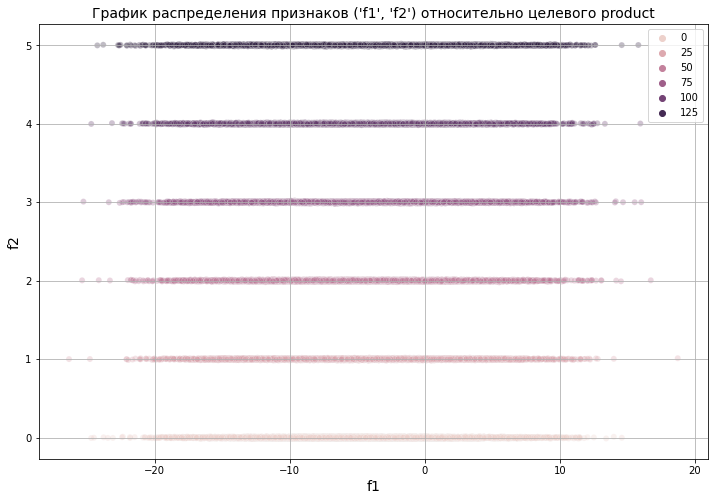

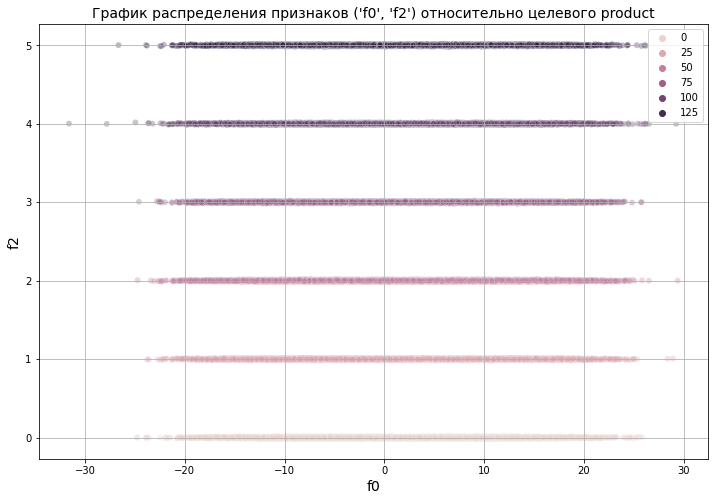

In [22]:
scatter(df_geo_2, 'f0', 'f1')
scatter(df_geo_2, 'f1', 'f2')
scatter(df_geo_2, 'f0', 'f2')

*Во второй таблице признак f2 полностью объясняет распределение целевого, мы это видим по четкой кластеризации на графиках. Также попробуем перемножить признаки + проверить на полиномы*

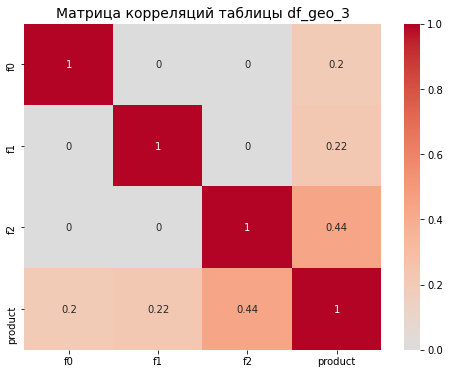

In [23]:
corr_data_3 = df_geo_3.drop('id', axis=1).copy()
col_int_3 = corr_data_3.select_dtypes(include='number').columns.to_list()
corr_3 = corr_data_3.phik_matrix(interval_cols=col_int_3)

plt.figure(figsize=(8,6))
sns.heatmap(data=corr_3, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций таблицы df_geo_3', fontsize=14)
plt.show()

*В таблице 3 ситуация самая благоприятная, поскольку между входными признаками взаимосвязи нет, тогда как с целевым связан каждый.*

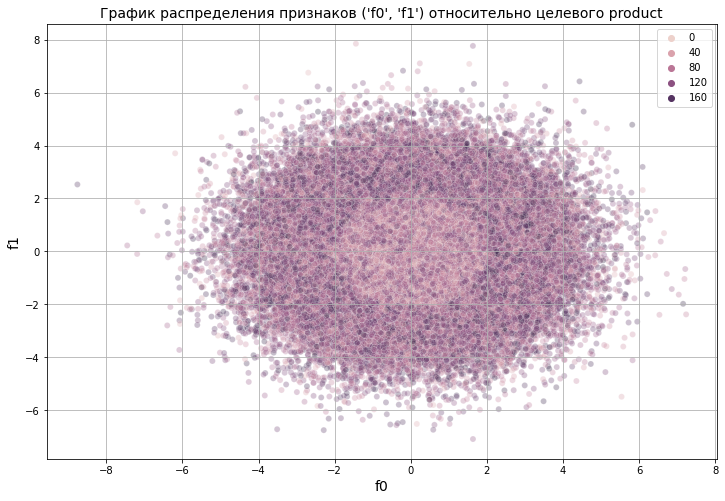

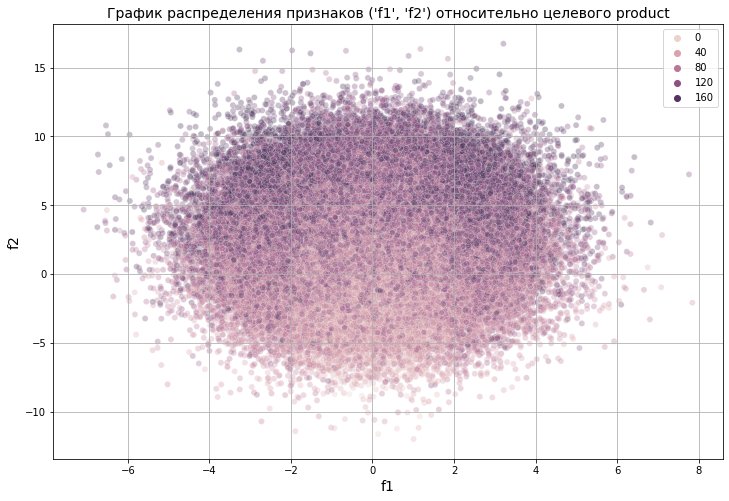

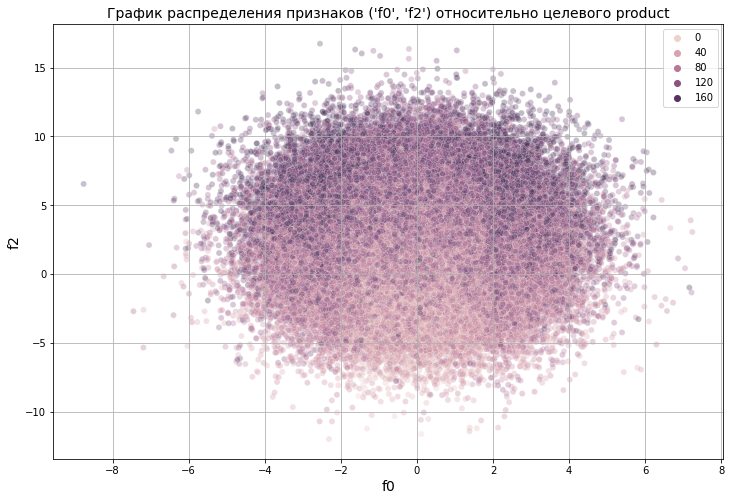

In [24]:
scatter(df_geo_3, 'f0', 'f1')
scatter(df_geo_3, 'f1', 'f2')
scatter(df_geo_3, 'f0', 'f2')

*В третьей таблице все признаки имеют нормальное распределение, но по отдельности они плохо объясняют целевой product, поскольку зависимости демонстрируют невысокие. Для улучшения метрик также проведем проверку на полиномы и добавим дополнительные признаки.*

## Обучение и проверка модели

### Сперва проверю работу модели на базовых таблицах

In [25]:
data_regions_test = [df_geo_1, df_geo_2, df_geo_3]

region_names = ['region_1', 'region_2', 'region_3']

for i, (df, region_name) in enumerate(zip(data_regions_test, region_names), start=1): 
    print(f'\nРегион {i}')
    features = df.drop(['id','product'], axis=1)
    target = df['product']
    X_train, X_valid, y_train, y_valid = train_test_split(features, 
                                                          target, 
                                                          test_size=0.25, 
                                                          random_state=42
                                                         )
                                                         
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_valid_scaled)
        
    results_df_base = pd.DataFrame({'actual': y_valid, 
                               'predicted': predictions})

    globals()[f'results_base_region_{i}'] = results_df_base

    mean_predicted = predictions.mean()
    rmse = mean_squared_error(y_valid, predictions, squared=False)
    
    print(f'Средний запас предсказанного сырья: {mean_predicted:.2f}')
    print(f'RMSE модели: {rmse:.2f}')


Регион 1
Средний запас предсказанного сырья: 92.40
RMSE модели: 37.76

Регион 2
Средний запас предсказанного сырья: 68.71
RMSE модели: 0.89

Регион 3
Средний запас предсказанного сырья: 94.77
RMSE модели: 40.15


**Метрики в результате получились удовлетворительные. Конечно, для такой задачи RMSE неплохо было бы 10-15, но мы не знаем природу признаков и поэтому не можем заявлять об ошибочности системы. Далее я попробую добавить новые признаки на основе уже имеющихся и посмотрим, как изменятся наши результаты.**

### Подготовка признаков

In [26]:
#функция для добавления новых признаков
def features(df):
    df = df.drop('id', axis=1)
    df['f0f1'] = df['f0'] * df['f1']
    df['f1f2'] = df['f1'] * df['f2']
    df['f0f2'] = df['f0'] * df['f2']
    columns = [col for col in df.columns if col != 'product'] + ['product']
    df = df[columns]
    return df

In [27]:
df_geo_1_prepared = df_geo_1.copy()
df_geo_2_prepared = df_geo_2.copy()
df_geo_3_prepared = df_geo_3.copy()

df_geo_1_prepared = features(df_geo_1_prepared)
df_geo_2_prepared = features(df_geo_2_prepared)
df_geo_3_prepared = features(df_geo_3_prepared)
display(df_geo_1_prepared.head(3))
display(df_geo_2_prepared.head(3))
display(df_geo_3_prepared.head(3))

,f0,f1,f2,f0f1,f1f2,f0f2,product
0,0.705745,-0.497823,1.221170,-0.351336,-0.607926,0.861835,105.280062
1,1.334711,-0.340164,4.365080,-0.454021,-1.484844,5.826122,73.037750
2,1.022732,0.151990,1.419926,0.155446,0.215815,1.452204,85.265647


,f0,f1,f2,f0f1,f1f2,f0f2,product
0,-15.001348,-8.276000,-0.005876,124.151157,0.048630,0.088148,3.179103
1,14.272088,-3.475083,0.999183,-49.596693,-3.472243,14.260424,26.953261
2,6.263187,-5.948386,5.001160,-37.255855,-29.748830,31.323203,134.766305


,f0,f1,f2,f0f1,f1f2,f0f2,product
0,-1.146987,0.963328,-0.828965,-1.104925,-0.798565,0.950812,27.758673
1,0.262778,0.269839,-2.530187,0.070908,-0.682743,-0.664877,56.069697
2,0.194587,0.289035,-5.586433,0.056243,-1.614675,-1.087049,62.871910


**Новые признаки в виде произведений имеющихся добавлены, теперь посмотрим и выберем полиномы**

In [28]:
#функция проверки полиномиальности
def polynomial(df):
    
    r_s = 42
    scaler = StandardScaler()
    
    X = df.drop(['product'], axis=1).copy()
    y = df['product'].copy()
    
    X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                          y,
                                                          test_size=0.25,
                                                          random_state=r_s)
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    
    degrees = range(2, 7)
    results = {}
    
    for degree in degrees:
        poly = PolynomialFeatures(degree=degree)
    
        X_poly_train = poly.fit_transform(X_train_scaled)
        X_poly_valid = poly.transform(X_valid_scaled)
    
        model = LinearRegression()
        model.fit(X_poly_train, y_train)
    
        y_pred_train = model.predict(X_poly_train)
        y_pred_valid = model.predict(X_poly_valid)
    
        rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
        rmse_valid = mean_squared_error(y_valid, y_pred_valid, squared=False)
    
        results[degree] = {
            'RMSE_train': rmse_train,
            'RMSE_valid': rmse_valid
        }
        
    for degree, metrics in results.items():
        print(f"Degree {degree}:")
        print(f"  RMSE_train: {metrics['RMSE_train']:.2f}")
        print(f"  RMSE_valid: {metrics['RMSE_valid']:.2f}")

In [29]:
polynomial(df_geo_1_prepared)

In [30]:
polynomial(df_geo_2_prepared)

In [31]:
polynomial(df_geo_3_prepared)

**Лучше всех проявили себя полиномы 5 степени, используем их**

In [32]:
#функция добавления полинома 5 степени в таблицы
def poly_add(df):
    true_list = df.columns.to_list()
    true_list.remove('product')
    for i in true_list:
        df[f'{i}_^5'] = df[i] ** 5
    columns = [col for col in df.columns if col != 'product'] + ['product']
    df = df[columns]
    return df

In [33]:
poly_add(df_geo_1_prepared)
display(df_geo_1_prepared.head(3))

,f0,f1,f2,f0f1,f1f2,f0f2,product,f0_^5,f1_^5,f2_^5,f0f1_^5,f1f2_^5,f0f2_^5
0,0.705745,-0.497823,1.221170,-0.351336,-0.607926,0.861835,105.280062,0.175081,-0.030575,2.715692,-0.005353,-0.083033,0.475466
1,1.334711,-0.340164,4.365080,-0.454021,-1.484844,5.826122,73.037750,4.235812,-0.004555,1584.751615,-0.019292,-7.217795,6712.709882
2,1.022732,0.151990,1.419926,0.155446,0.215815,1.452204,85.265647,1.118948,0.000081,5.772035,0.000091,0.000468,6.458605


In [34]:
poly_add(df_geo_2_prepared)
display(df_geo_2_prepared.head(3))

,f0,f1,f2,f0f1,f1f2,f0f2,product,f0_^5,f1_^5,f2_^5,f0f1_^5,f1f2_^5,f0f2_^5
0,-15.001348,-8.276000,-0.005876,124.151157,0.048630,0.088148,3.179103,-759716.320043,-38824.189323,-7.005094e-12,2.949537e+10,2.719671e-07,5.321885e-06
1,14.272088,-3.475083,0.999183,-49.596693,-3.472243,14.260424,26.953261,592157.924400,-506.787674,9.959204e-01,-3.000983e+08,-5.047202e+02,5.897421e+05
2,6.263187,-5.948386,5.001160,-37.255855,-29.748830,31.323203,134.766305,9637.780151,-7447.244918,3.128627e+03,-7.177491e+07,-2.329965e+07,3.015302e+07


In [35]:
poly_add(df_geo_3_prepared)
display(df_geo_3_prepared.head(3))

,f0,f1,f2,f0f1,f1f2,f0f2,product,f0_^5,f1_^5,f2_^5,f0f1_^5,f1f2_^5,f0f2_^5
0,-1.146987,0.963328,-0.828965,-1.104925,-0.798565,0.950812,27.758673,-1.985147,0.829604,-0.391454,-1.646886e+00,-0.324752,0.777094
1,0.262778,0.269839,-2.530187,0.070908,-0.682743,-0.664877,56.069697,0.001253,0.001431,-103.696162,1.792534e-06,-0.148349,-0.129929
2,0.194587,0.289035,-5.586433,0.056243,-1.614675,-1.087049,62.871910,0.000279,0.002017,-5440.926804,5.627616e-07,-10.975519,-1.517907


**Полиномы добавили, теперь поиграем с проблемными признаками каждой таблицы**

In [36]:
def k_best_check(df):
    r_s = 42
    selector = SelectKBest(score_func=f_regression, k=8)
    
    X = df.drop(['product'], axis=1).copy()
    y = df['product'].copy()

    X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                          y,
                                                          test_size=0.25,
                                                          random_state=r_s)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    
    X_selected = selector.fit_transform(X_train_scaled, y_train)
    
    print("Выбранные признаки:", X.columns[selector.get_support()])

In [37]:
k_best_check(df_geo_1_prepared)

Выбранные признаки: Index(['f0', 'f1', 'f2', 'f0f2', 'f0_^5', 'f1_^5', 'f2_^5', 'f0f2_^5'], dtype='object')


In [38]:
k_best_check(df_geo_2_prepared)

Выбранные признаки: Index(['f0', 'f2', 'f0f1', 'f1f2', 'f0f2', 'f2_^5', 'f1f2_^5', 'f0f2_^5'], dtype='object')


In [39]:
k_best_check(df_geo_3_prepared)

Выбранные признаки: Index(['f0', 'f2', 'f0f1', 'f0_^5', 'f1_^5', 'f2_^5', 'f0f1_^5', 'f0f2_^5'], dtype='object')


In [40]:
df_geo_1_prepared = df_geo_1_prepared[['f0', 'f1', 'f2', 'f0f2', 'f0_^5', 'f1_^5', 'f2_^5', 'f0f2_^5', 'product']]
df_geo_2_prepared = df_geo_2_prepared[['f0', 'f2', 'f0f1', 'f1f2', 'f0f2', 'f2_^5', 'f1f2_^5', 'f0f2_^5', 'product']]
df_geo_3_prepared = df_geo_3_prepared[['f0', 'f2', 'f0f1', 'f0_^5', 'f1_^5', 'f2_^5', 'f0f1_^5', 'f0f2_^5', 'product']]

**Отобрали лучшие признаки, теперь переходим к обучению и проверке модели. В таблице 2 я не стал убирать признак f2, поскольку не могу знать является он ошибочным или очень важным для расчетов модели. Заказчик информацию не раскрывает**

### Обучение и проверка модели

In [41]:
data_regions = [df_geo_1_prepared, df_geo_2_prepared, df_geo_3_prepared]
region_names = ['region_1', 'region_2', 'region_3']

for i, (df, region_name) in enumerate(zip(data_regions, region_names), start=1): 
    #start = 1, чтобы отсчет регионов начинался с 1, а не с 0
    #подсмотрел функцию zip, чтобы перебирать цикл не только по регионам, но и по их именам
    
    print(f'\nРегион {i}')
    features = df.drop(['product'], axis=1)
    target = df['product']
    X_train, X_valid, y_train, y_valid = train_test_split(features, 
                                                          target, 
                                                          test_size=0.25, 
                                                          random_state=42
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_valid_scaled)
        
    results_df = pd.DataFrame({'actual': y_valid, 
                               'predicted': predictions})

    globals()[f'results_region_{i}'] = results_df 
    #тоже подсмотрел метод, который создает мне 3 отдельные таблицы с результатами прямо в теле цикла
    #с именами results_region_1, results_region_2, results_region_3
    
    mean_predicted = predictions.mean()
    rmse = mean_squared_error(y_valid, predictions, squared=False)
    
    print(f'Средний запас предсказанного сырья: {mean_predicted:.2f}')
    print(f'RMSE модели: {rmse:.2f}')


Регион 1
Средний запас предсказанного сырья: 92.42
RMSE модели: 37.64

Регион 2
Средний запас предсказанного сырья: 68.71
RMSE модели: 0.88

Регион 3
Средний запас предсказанного сырья: 94.77
RMSE модели: 40.12


**Вывод**

**На деле результаты чуть-чуть улучшились, разброс стал чуть меньше по сравнению с базовыми таблицами. Для улучшения показателей стоит узнать у заказчика о возможных дополнительных данных или раскрыть настоящее описание входных признаков**

**Наибольший предсказанный запас сырья в регионе 3 и регионе 1**

## Подготовка к расчёту прибыли

In [42]:
break_even_volume = budget / (unit_price * num_wells)

mean_product_region_1 = df_geo_1['product'].mean()
mean_product_region_2 = df_geo_2['product'].mean()
mean_product_region_3 = df_geo_3['product'].mean()

print(f"Достаточный объём сырья для безубыточности: {break_even_volume:.2f}")
print(f"Средний запас сырья в регионе 1: {mean_product_region_1:.2f}")
print(f"Средний запас сырья в регионе 2: {mean_product_region_2:.2f}")
print(f"Средний запас сырья в регионе 3: {mean_product_region_3:.2f}")

Достаточный объём сырья для безубыточности: 111.11
Средний запас сырья в регионе 1: 92.50
Средний запас сырья в регионе 2: 68.83
Средний запас сырья в регионе 3: 95.00


**Вывод**

**Рассчитали достаточный объем для безубыточности скважины. Как мы видим, средний запас сырья по регионам ниже объема 111.11 тыс. баррелей, что в свою очередь означает, что большая часть скважин являются убыточными. Далее возьмем наиболее успешные объекты и приступим к расчетам прибыли и рисков.**

## Расчёт прибыли и рисков 

### Сначала  смотрим результаты базовых таблиц

In [43]:
def bootstrap_profit(df, target, predictions, region):
    np.random.seed(42) #sample автоматически берет это значение для random_state
    profits = []
    
    for i in range(n_samples):
        sample = df.sample(n=sample_size, replace=True)
        best_objects = sample.sort_values(by=predictions, ascending=False).head(num_wells)
        selected_target_volume = best_objects[target].sum()
        revenue = selected_target_volume * unit_price
        profit = revenue - budget
        profits.append(profit)
    
    mean_profit = np.mean(profits)
    lower_bound = np.percentile(profits, 2.5)
    upper_bound = np.percentile(profits, 97.5)
    loss_risk = (np.array(profits) < 0).mean()
    
    print(f"\n{region}:")
    print(f"Средняя прибыль: {mean_profit:.2f} руб.")
    print(f"95%-й доверительный интервал: от {lower_bound:.2f} руб. до {upper_bound:.2f} руб.")
    print(f"Риск убытков: {loss_risk:.1%}")

In [44]:
bootstrap_profit(results_base_region_1, 'actual', 'predicted', 'Регион 1')
bootstrap_profit(results_base_region_2, 'actual', 'predicted', 'Регион 2')
bootstrap_profit(results_base_region_3, 'actual', 'predicted', 'Регион 3')


Регион 1:
Средняя прибыль: 399575478.05 руб.
95%-й доверительный интервал: от -110467895.33 руб. до 897460327.72 руб.
Риск убытков: 6.0%

Регион 2:
Средняя прибыль: 452048890.91 руб.
95%-й доверительный интервал: от 61684479.65 руб. до 845340177.51 руб.
Риск убытков: 1.5%

Регион 3:
Средняя прибыль: 375009902.92 руб.
95%-й доверительный интервал: от -144766727.30 руб. до 888390403.53 руб.
Риск убытков: 8.0%


### Теперь  смотрим результаты таблиц с новыми признаками

In [45]:
bootstrap_profit(results_region_1, 'actual', 'predicted', 'Регион 1')
bootstrap_profit(results_region_2, 'actual', 'predicted', 'Регион 2')
bootstrap_profit(results_region_3, 'actual', 'predicted', 'Регион 3')


Регион 1:
Средняя прибыль: 404983209.84 руб.
95%-й доверительный интервал: от -137320747.11 руб. до 904544509.36 руб.
Риск убытков: 5.4%

Регион 2:
Средняя прибыль: 452036015.54 руб.
95%-й доверительный интервал: от 61684479.65 руб. до 845340177.51 руб.
Риск убытков: 1.5%

Регион 3:
Средняя прибыль: 373300451.33 руб.
95%-й доверительный интервал: от -151402282.64 руб. до 885390579.41 руб.
Риск убытков: 8.4%


**Вывод**


**По базовой таблице результаты по региону 1 чуть ниже, чем по новой, а вот по остальным регионам показатели прибыли чуть выше - возможно, что модель слегка переоценивает предсказания относительно существующих. В обоих случаях Регион 2 демонстрирует лучшие результаты.**


**Порогу в 2.5% риска убытков соответствует Регион 2, где риск получается всего 1.5%**


**Самым прибыльным регионом согласно расчетам прибыли также является Регион 2 с результатом 452036015.54 руб., далее Регион 1 = 404983209.84 руб., далее Регион 3 с результатом 373300451.33 руб.**


**Согласно техническому заданию заказчика, я рекомендую для разработки Регион 2. Здесь риск убытков всего 1.5%, а потенциальная средняя прибыль самая высокая.**

## Заключение

**В данном проекте стояла задача построить модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой Bootstrap.**

- Моделью для предсказаний целевого признака была выбрана Линейная Регрессия (остальные — недостаточно предсказуемые согласно ТЗ).

- Базовый набор признаков давал удовлетворительные метрики во время модеилрования, мной также была проведена работа по добавлению новых входных показателей на основе уже имеющихся. В результате удалось добиться меньших отклонений в предсказаниях модели от действительности.

- Наибольшая средняя прибыль по результатам работы в Регионе 2 и составляет 452036015.54 руб.

- Регион 2 также является наименее рисковым (всего 1.5%).

- Я рекомендую именно Регион 2 для дальнейшей разработки, поскольку он отвечает всем поставленным условиям. Однако, стоит основательно подходить к выбору скважин, поскольку в данном регионе средний запас сырья по объектам ниже остальных, а значит больше убыточных скважин.

- В ходе работы были устранены некоторые явные дубликаты. Проведен исследовательский и корреляционный анализы признаков. Были добавлены новые входные параметры для улучшения качества предсказаний модели.

*Как можно улучшить результаты работы:*

- Для улучшения метрик модели можно запросить дополнительной информации у заказчика. Возможно, есть данные о других признаках, что повысит точность предсказаний. Либо более понятное пояснение таких признаков как f2 во второй таблице, который почти полностью объясняет целевой признак.

- Можно, потенциально, использовать более сложные модели вроде Градиентного бустинга или Рандомного леса, к тому же в первом регионе f0 и f1 имели сильную нелинейную зависимость, котору линейная регрессия не объясняет.